In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

In [2]:
def get_image_points(image):
    image_size = (image.shape[1],image.shape[0])
    objectpoints  = np.zeros((6*9,3),np.float32)
    objectpoints[:,:2] =  np.mgrid[0:9, 0:6].T.reshape(-1,2)
    ret,pointsonimage = cv2.findChessboardCorners(image,(9,6),flags = cv2.CALIB_CB_ADAPTIVE_THRESH)
    if ret == True:
        cv2.drawChessboardCorners(image,(9,6),pointsonimage,ret)
        return ret,objectpoints,pointsonimage
    else:
        return False,objectpoints,pointsonimage

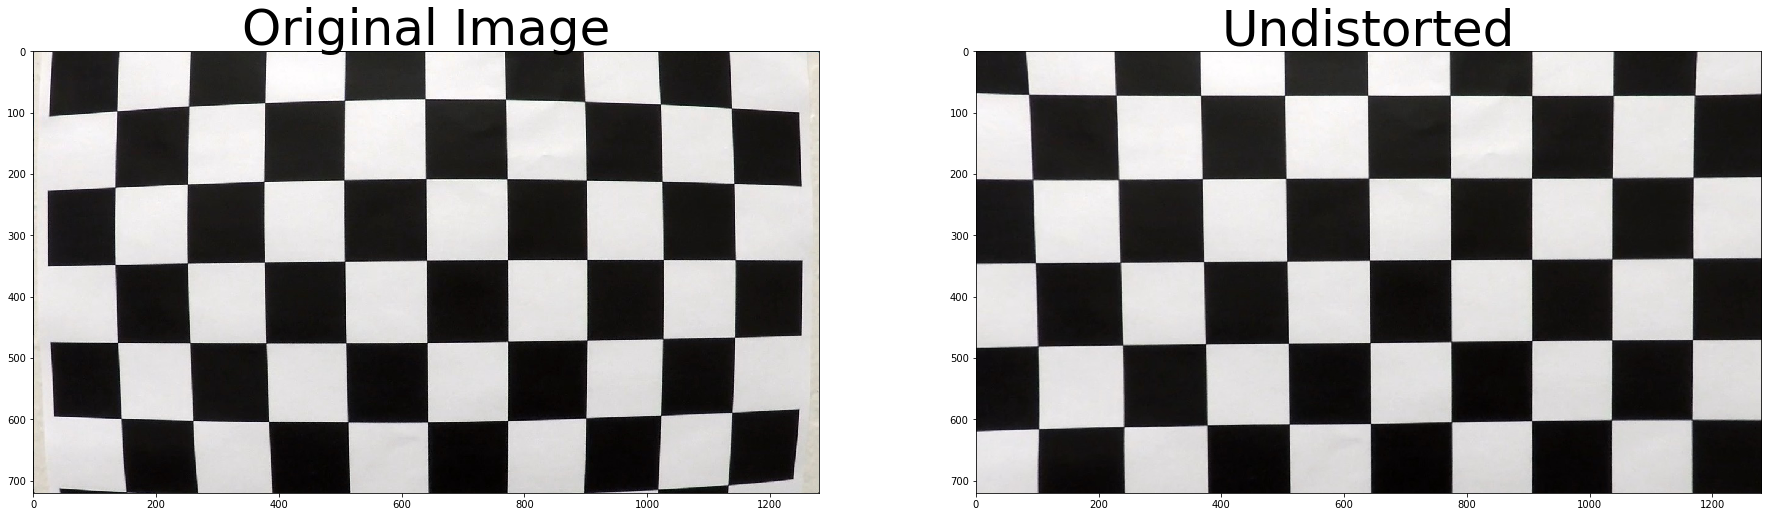

In [3]:
def calibrate_camera(image_path=None):
    images = glob.glob('camera_cal/calibration*.jpg')
    objectpoints_=[]
    pointsonimage_ = []
    for index,image in enumerate(images):
        image_ = mpimg.imread(image)
        ret,objectpoints,pointsonimage = get_image_points(image_)
        if ret == True:
            objectpoints_.append(objectpoints)
            pointsonimage_.append(pointsonimage)
                                  
    test_image = mpimg.imread(image_path)
    image_size = (test_image.shape[1],test_image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints_, pointsonimage_, image_size,None,None)
    dst = cv2.undistort(test_image, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    ax1.imshow(test_image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(dst)
    ax2.set_title('Undistorted', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return mtx,dist
    
mtx,dist = calibrate_camera('camera_cal/TestImage.jpg')
    

In [4]:
def undistort(image,mtx,dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

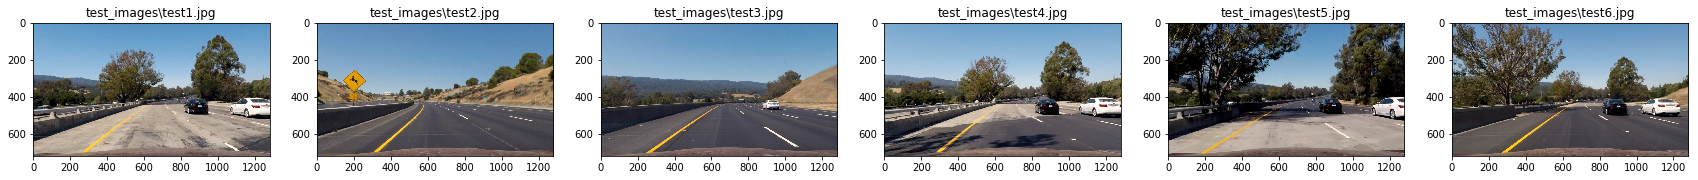

In [5]:
def undistort_images(mtx,dist):
    test_images = glob.glob('test_images/test*.jpg')
    plt.figure(figsize=(50, 10))
    count=1
    for index,image in enumerate(test_images):
        plt.subplot(2,10,count)
        image_ = mpimg.imread(image)
        image_ = undistort(image_,mtx,dist)
        image_copy = np.copy(image_)
        image_copy = cv2.cvtColor(image_copy,cv2.COLOR_RGB2BGR)
        write_name = 'output_images/undistorted'+str(index)+'.jpg'
        cv2.imwrite(write_name, image_copy)
        plt.imshow(image_)
        plt.title(image)
        count = count+1
    
undistort_images(mtx,dist)

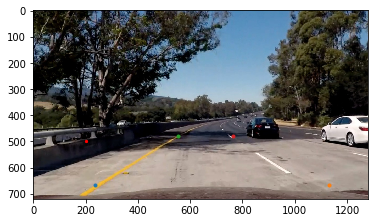

In [6]:
temp_=mpimg.imread('output_images/undistorted4.jpg')
plt.imshow(temp_)
plt.scatter([200],[500],c='r',s=5)
plt.plot(235,665,'.')
plt.plot(1130,665,'.')
plt.plot(555,480,'.')
plt.plot(765,480,'.')

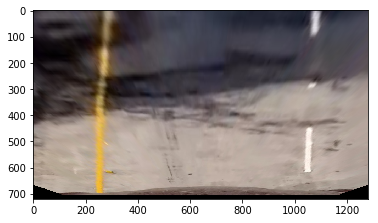

In [7]:
src_corners = np.float32([[235,665],[1130,665],[555,480],[765,480]])
dest_corners = np.float32([[235,665],[1130,665],[285,0],[1130,0]])
M = cv2.getPerspectiveTransform(src_corners, dest_corners)
M_inv = cv2.getPerspectiveTransform(dest_corners,src_corners)
def perspective_transform(image):
    warped = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))
    return warped

temp_ = perspective_transform(temp_)
plt.imshow(temp_)
    

In [8]:
def perspective_transform_images(image_path,output_path):
    images = glob.glob(image_path)
    for index,images in enumerate(images):
        temp_= mpimg.imread(images)
        wraped_output = perspective_transform(temp_)
        wraped_output = cv2.cvtColor(wraped_output,cv2.COLOR_RGB2BGR)
        write_name = output_path+'/wraped'+str(index)+'.jpg'
        cv2.imwrite(write_name, wraped_output)
        
perspective_transform_images('output_images/undistorted*.jpg','output_images')
        

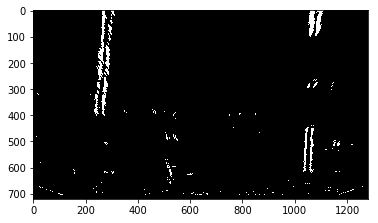

In [9]:
def absgradient(image,thres=(20,100)):
    image_ = np.copy(image)
    image_gray = cv2.cvtColor(image_,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(image_gray,cv2.CV_64F,1,0)
    abs_image = np.absolute(sobelx)
    scaled = np.uint8(255*abs_image/np.max(abs_image))
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled > thres[0]) & (scaled <= thres[1])] = 1
    return binary_output
    
tempgrad_ = absgradient(temp_)
plt.imshow(tempgrad_,cmap = 'gray')    

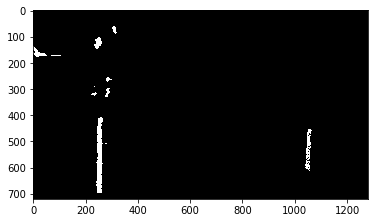

In [10]:
def HLSprocess(image,thres=(170,255)):
    hlsimage = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    hlsimage = hlsimage[:,:,2]
    binary_output = np.zeros_like(hlsimage)
    binary_output[(hlsimage > thres[0]) & (hlsimage <= thres[1])] =1
    return binary_output

temphslprocess_ = HLSprocess(temp_)
plt.imshow(temphslprocess_,cmap = 'gray')

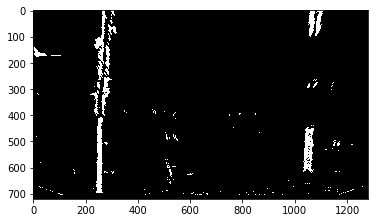

In [11]:
final_output = np.zeros_like(tempgrad_)
final_output[(tempgrad_ == 1) | (temphslprocess_ == 1)] = 1
plt.imshow(final_output,cmap ='gray')

In [12]:
def grad_color_images(image_path,output_path):
    images = glob.glob(image_path)
    for index,images in enumerate(images):
        temp_= mpimg.imread(images)
        tempgrad_ = absgradient(temp_)
        temphslprocess_ = HLSprocess(temp_)
        final_output = np.zeros_like(tempgrad_)
        final_output[(tempgrad_ == 1) | (temphslprocess_ == 1)] = 1
        write_name = output_path+'/gradcolor'+str(index)+'.jpg'
        plt.imsave(write_name, final_output,cmap = 'gray')

grad_color_images('output_images/wraped*.jpg','output_images')
    

In [13]:
def l_channel(image,thres=(150,255)):
        hlsimage = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        hlsimage = hlsimage[:,:,1]
        binary_output = np.zeros_like(hlsimage)
        binary_output[(hlsimage > thres[0]) & (hlsimage <= thres[1])] =1
        return binary_output


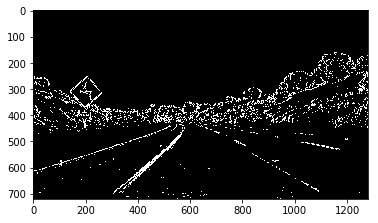

In [14]:
test_image_ = mpimg.imread('output_images/undistorted1.jpg')
test_image_grad = absgradient(test_image_)
test_image_s = HLSprocess(test_image_)
test_image_l = l_channel(test_image_)
test_binary_ = np.zeros_like(test_image_l)
test_binary_[((test_image_l == 1) & (test_image_s == 1)) | (test_image_grad == 1)] =1
plt.imshow(test_binary_,cmap = 'gray')
plt.imsave('output_images/final_process.jpg',test_binary_,cmap = 'gray')

In [15]:
from collections import deque
leftpix_mean = deque(maxlen = 10)
rightpix_mean = deque(maxlen = 10)

# Lane Line detection 

In [16]:
def lines(image,video = False):
    binary_warped = image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    histogram = np.sum(binary_warped, axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 100
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    #     print('left',good_left_inds)
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    #     print('right',good_right_inds)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
#     print(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
#     print(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit1 = np.polyfit(lefty, leftx, 2)
    right_fit1 = np.polyfit(righty, rightx, 2)
    temp_left_fit = np.copy(left_fit1)
    temp_right_fit = np.copy(right_fit1)
    leftpix_mean.append(temp_left_fit)
    rightpix_mean.append(temp_right_fit)
    left_fit = np.average(leftpix_mean,axis = 0)
    right_fit = np.average(rightpix_mean,axis = 0)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    window_img = np.zeros_like(out_img)
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    if video == False:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
#     return result
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    color_wrap = cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    radius = (left_curverad+right_curverad)//2
    
    
    ##########distance from center########################
    car_position = image.shape[1]/2
    left_fit_center = left_fit[0]*image.shape[0]**2 + left_fit[1]*image.shape[0] + left_fit[2]
    right_fit_center = right_fit[0]*image.shape[0]**2 + right_fit[1]*image.shape[0] + right_fit[2]
    lane_center_position = (right_fit_center + left_fit_center) /2
    center_dist = (car_position - lane_center_position) * xm_per_pix
    if video == False:
        return radius,color_warp,center_dist,result
    else:
        return radius,color_warp,center_dist
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

radius 1494.0
center -0.3099076492521572
radius 3248.0
center -0.3063266627466522
radius 6027.0
center -0.27706772943958413
radius 3951.0
center -0.33186812516800307
radius 4036.0
center -0.2745836603730049
radius 2330.0
center -0.3160646964444567


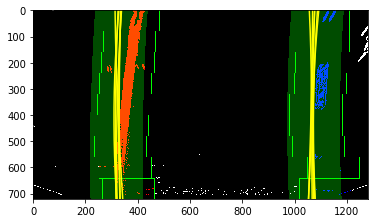

In [17]:
images = glob.glob('output_images/undistorted*.jpg')
for index,images in enumerate(images):
    distort_ = mpimg.imread(images)
#     distort_ = undistort(image_,mtx,dist)
    perspec_ = perspective_transform(distort_)
    abs_grad = absgradient(perspec_)
    hls_ = HLSprocess(perspec_)
    l_ = l_channel(perspec_)
    grad_ =np.zeros_like(abs_grad)
    grad_[((hls_ == 1) & (l_ == 1)) | (abs_grad == 1)] =1
#     grad_ = np.dstack((grad_,grad_,grad_))*255
    radius,final_output,center_dist,result= lines(grad_)
    print('radius',radius)
    print('center',center_dist)
    write_name = 'output_images'+'/lines'+str(index)+'.jpg'
    cv2.imwrite(write_name, result)
    newwarp = cv2.warpPerspective(final_output, M_inv, (distort_.shape[1], distort_.shape[0])) 
#     # Combine the result with the original image
    result1 = cv2.addWeighted(distort_, 1, newwarp, 0.3, 0)
    result1 = cv2.putText(result1, 'Radius '+str(round(radius,4))+'m', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    if(center_dist < 0):
        result1 = cv2.putText(result1, ' Left Distance from center '+str(round(center_dist,4))+'m', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    else:
        result1 = cv2.putText(result1, ' Right Distance from center '+str(round(center_dist,4))+'m', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    write_name2 = 'output_images'+'/final_output'+str(index)+'.jpg'
    plt.imsave(write_name2,result1)

In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def pipeline(image):
    distort_ = undistort(image,mtx,dist)
    perspec_ = perspective_transform(distort_)
    abs_grad = absgradient(perspec_)
    hls_ = HLSprocess(perspec_)
    l_ = l_channel(perspec_)
    grad_ =np.zeros_like(hls_)
    grad_[((hls_ == 1) & (l_ == 1)) | (abs_grad == 1)] =1
#     plt.imshow(grad_,cmap = 'gray')
    final_output = np.dstack((grad_,grad_,grad_))*255
    radius,final_output,center_dist = lines(grad_,True)
    newwarp = cv2.warpPerspective(final_output, M_inv, (image.shape[1], image.shape[0])) 
#     # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = cv2.putText(result, 'Radius '+str(round(radius,4))+'m', (10, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    if(center_dist < 0):
        result = cv2.putText(result, ' Left Distance from center '+str(round(-center_dist,4))+'m', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    else:
        result = cv2.putText(result, ' Right Distance from center '+str(round(center_dist,4))+'m', (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
#     plt.imshow(result)
    return result
#     return final_output     

In [21]:
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:19<00:00,  6.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 20s
